# Giới thiệu
Công ty AdventureWorks với dữ liệu bán hàng từ cuối năm 2010 (tháng 12) đến đầu năm 2014 (tháng 1) muốn dự đoán doanh thu trong năm 2014.

# I. Chuẩn bị dữ liệu
1. Loại bỏ dữ liệu trùng lặp
2. Chọn ra các thuộc tính phù hợp

In [1]:
# Uncomment và chạy để cài đặt thư viện pmdarima
#pip install pmdarima

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

In [3]:
server_name = 'DESKTOP-TOL1F2F\MSSQLSERVERBI'
database_name = 'AdventureWorksDW2012'

connection = pyodbc.connect('Driver={SQL Server}; Server=' + server_name +
                      '; Database=' + database_name +
                      '; Trusted_Connection=yes;')

In [4]:
df = pd.read_sql_query("SELECT * FROM [dbo].[FactInternetSales];", connection) 

df.head()

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.2700,286.2616,89.4568,None,None,2010-12-29,2011-01-10,2011-01-05
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,None,None,2010-12-29,2011-01-10,2011-01-05
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,None,None,2010-12-29,2011-01-10,2011-01-05
3,336,20101229,20110110,20110105,14501,1,100,4,SO43700,1,...,413.1463,413.1463,699.0982,55.9279,17.4775,None,None,2010-12-29,2011-01-10,2011-01-05
4,346,20101229,20110110,20110105,11003,1,6,9,SO43701,1,...,1912.1544,1912.1544,3399.9900,271.9992,84.9998,None,None,2010-12-29,2011-01-10,2011-01-05


## 1. Loại bỏ dữ liệu trùng lặp

In [5]:
# Kiểm tra dữ liệu trùng lặp
df.duplicated(subset=None, keep='first')

0        False
1        False
2        False
3        False
4        False
         ...  
60393    False
60394    False
60395    False
60396    False
60397    False
Length: 60398, dtype: bool

In [6]:
# Loại bỏ trùng lặp
df.drop_duplicates(inplace=True)
print(df.head())
df.shape

   ProductKey  OrderDateKey  DueDateKey  ShipDateKey  CustomerKey  \
0         310      20101229    20110110     20110105        21768   
1         346      20101229    20110110     20110105        28389   
2         346      20101229    20110110     20110105        25863   
3         336      20101229    20110110     20110105        14501   
4         346      20101229    20110110     20110105        11003   

   PromotionKey  CurrencyKey  SalesTerritoryKey SalesOrderNumber  \
0             1           19                  6          SO43697   
1             1           39                  7          SO43698   
2             1          100                  1          SO43699   
3             1          100                  4          SO43700   
4             1            6                  9          SO43701   

   SalesOrderLineNumber  ...  ProductStandardCost  TotalProductCost  \
0                     1  ...            2171.2942         2171.2942   
1                     1  ...      

(60398, 26)

## 2. Chọn ra các thuộc tính phù hợp

In [7]:
# Chỉ lấy 2 thuộc tính là OrderDate và SalesAmount
df = df[['OrderDate', 'SalesAmount']]
df.head()

,OrderDate,SalesAmount
0,2010-12-29,3578.2700
1,2010-12-29,3399.9900
2,2010-12-29,3399.9900
3,2010-12-29,699.0982
4,2010-12-29,3399.9900


# II. Thống kê mô tả
1. Thống kê kích thước tập dữ liệu
2. Thống kê các độ đo trung tâm, phân tán
3. Thống kê số lượng dữ liệu missing

## 1. Thống kê kích thước tập dữ liệu
- Tập dữ liệu được chọn có kích thước 2 cột và 60398 dòng
- Có 1 thuộc tính kiểu thời gian là OrderDate
- Thuộc tính SalesAmount (doanh thu) là kiểu số thực 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60398 entries, 0 to 60397
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderDate    60398 non-null  datetime64[ns]
 1   SalesAmount  60398 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 MB


## 2. Thống kê các độ đo trung tâm, phân tán
- Tham số datetime_is_numeric=True để tắt đi cảnh báo dữ liệu thời gian khi chạy hàm describe()
- Tập dữ liệu trải dài từ 29/12/2010 đến 28/01/2014

In [9]:
df.describe(datetime_is_numeric=True)

,OrderDate,SalesAmount
count,60398,60398.000000
mean,2013-06-09 12:21:38.903937536,486.086911
min,2010-12-29 00:00:00,2.290000
25%,2013-04-03 00:00:00,7.950000
50%,2013-07-14 00:00:00,29.990000
75%,2013-10-18 00:00:00,539.990000
max,2014-01-28 00:00:00,3578.270000
std,NaN,928.489892


## 3. Thống kê số lượng dữ liệu missing
- Tập dữ liệu chọn ra có dữ liệu đầy đủ trên các cột

In [10]:
df.isna().sum()

OrderDate      0
SalesAmount    0
dtype: int64

# III. Xử lý dữ liệu
Tính tổng doanh thu theo từng tháng của năm phục vụ cho trực quan hoá dữ liệu theo thời gian.

In [11]:
# Format cột OrderDate lại thành dạng Y-m
df['OrderDate'] = pd.to_datetime(df['OrderDate'].dt.strftime('%Y-%m'), format='%Y-%m')
# Xử lý OrderDate, tính SalesAmount theo từng tháng của năm

df = df.groupby(['OrderDate']).sum()
df = df.sort_index()
df.head()

,SalesAmount
OrderDate,
2010-12-01,43421.0364
2011-01-01,469823.9148
2011-02-01,466334.9030
2011-03-01,485198.6594
2011-04-01,502073.8458


# IV. Trực quan hoá dữ liệu
1. Doanh thu qua từng năm
2. Doanh thu giữa các tháng qua từng năm
3. Seasonal decompose
4. Autocorrelation plot
5. Lagplot

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Doanh thu qua từng năm

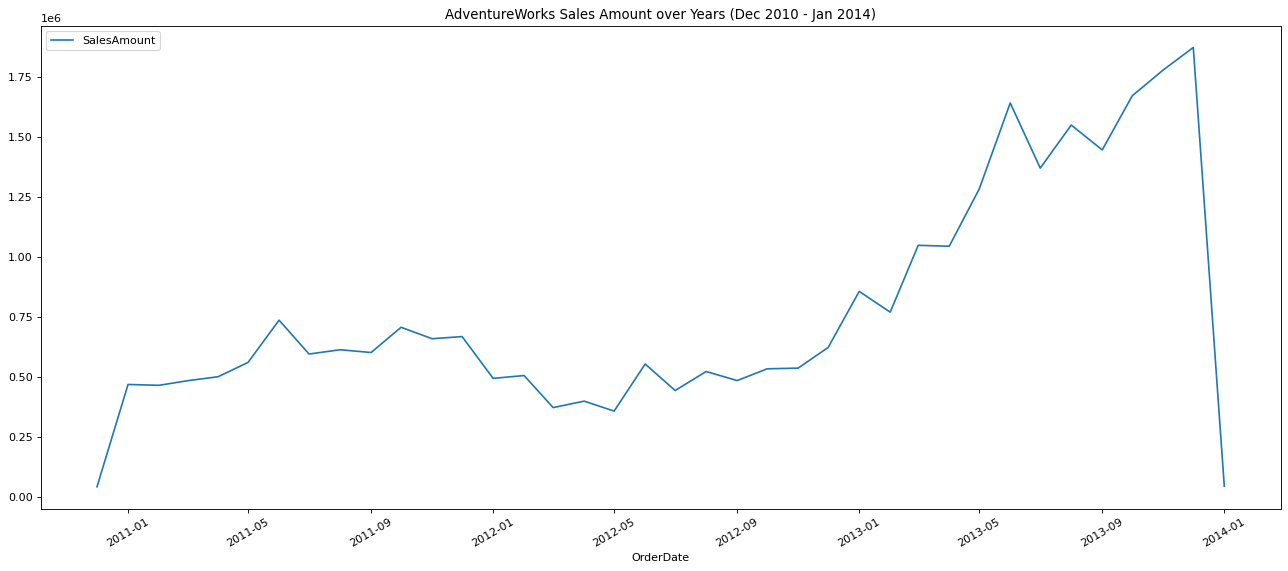

In [13]:
plt.figure(figsize=(20, 8), dpi=80)
plt.xticks(rotation=30)
plt.title('AdventureWorks Sales Amount over Years (Dec 2010 - Jan 2014)')
sns.lineplot(data=df)
plt.show()

Nhận xét:
- Doanh thu thường giảm nhẹ ở đầu năm, tăng nhiều ở dịp cuối năm.
- Doanh thu tăng trưởng mạnh vào cuối năm 2012 đầu năm 2013

Nhận thấy được dữ liệu năm 2014 chỉ có ở tháng 1, năm 2010 chỉ có tháng 12. Thực hiện loại bỏ dữ liệu này, chỉ giữ lại khoảng 2011-2013 để dự đoán.

In [14]:
df = df[(df.index >= pd.to_datetime('2011-01')) & (df.index <= pd.to_datetime('2013-12'))]
print(df.head())
print(df.tail())

            SalesAmount
OrderDate              
2011-01-01  469823.9148
2011-02-01  466334.9030
2011-03-01  485198.6594
2011-04-01  502073.8458
2011-05-01  561681.4758
            SalesAmount
OrderDate              
2013-08-01   1551065.56
2013-09-01   1447495.69
2013-10-01   1673293.41
2013-11-01   1780920.06
2013-12-01   1874360.29


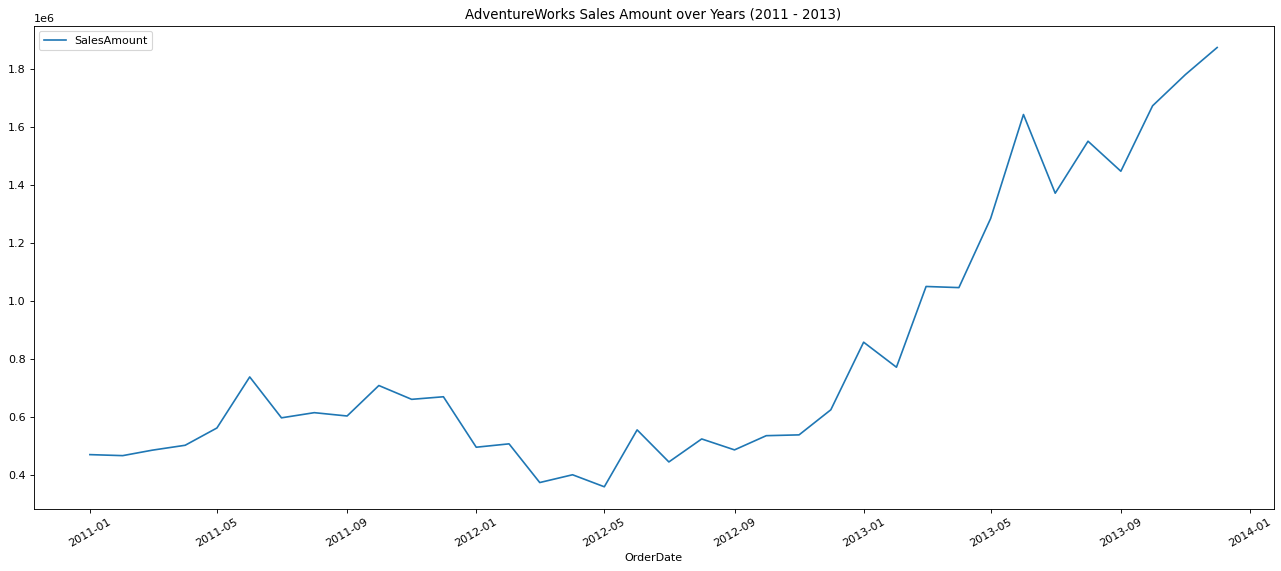

In [15]:
plt.figure(figsize=(20, 8), dpi=80)
plt.xticks(rotation=30)
plt.title('AdventureWorks Sales Amount over Years (2011 - 2013)')
sns.lineplot(data=df)
plt.show()

## 2. Doanh thu giữa các tháng qua từng năm

            SalesAmount  year month
OrderDate                          
2011-01-01  469823.9148  2011   Jan
2011-02-01  466334.9030  2011   Feb
2011-03-01  485198.6594  2011   Mar
2011-04-01  502073.8458  2011   Apr
2011-05-01  561681.4758  2011   May


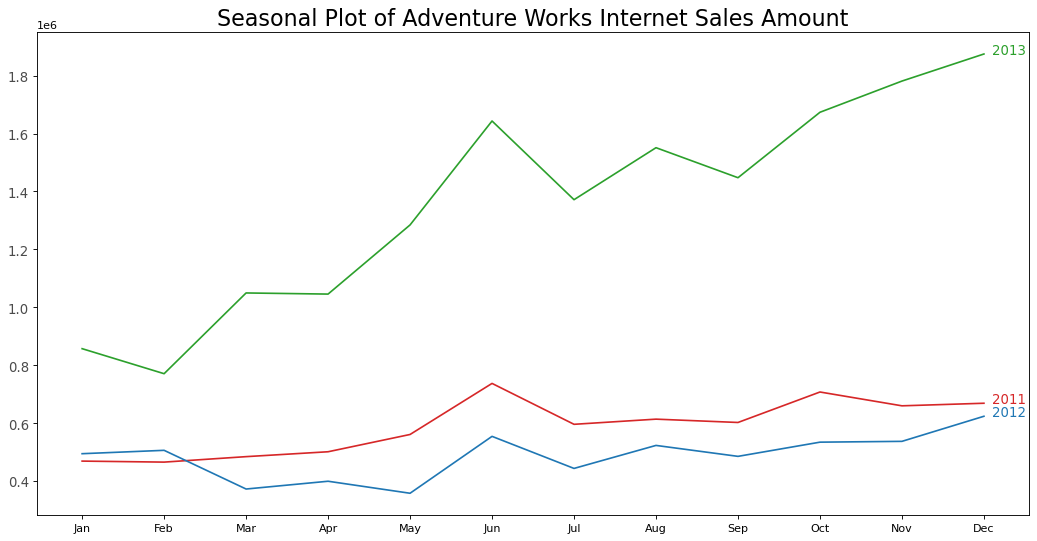

In [16]:
def make_seasonal_plot():
    df_copy = df.copy()
    df_copy['year'] = [d.year for d in df_copy.index]
    df_copy['month'] = [d.strftime('%b') for d in df_copy.index]
    print(df_copy.head())
    years = df_copy['year'].unique()

    # Chuẩn bị màu cho biểu đồ
    np.random.seed(100)
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 'firebrick', 'mediumseagreen']

    # Vẽ biểu đồ
    plt.figure(figsize=(16,8), dpi= 80)
    for i, y in enumerate(years):      
        plt.plot('month', 'SalesAmount', data=df_copy.loc[df_copy.year==y, :], color=mycolors[i], label=y)
        plt.text(df_copy.loc[df_copy.year==y, :].shape[0]-.9, df_copy.loc[df_copy.year==y, 'SalesAmount'][-1:].values[0], y, fontsize=12, color=mycolors[i])

    plt.ylabel='Sales Amount'
    plt.xlabel='Month'
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("Seasonal Plot of Adventure Works Internet Sales Amount", fontsize=20)
    plt.show()

make_seasonal_plot()

Nhận xét:
- Doanh thu tăng mạnh vào giai đoạn giữa và gần cuối năm, lặp lại qua các năm.
- Giai đoạn giữa năm có thể là do dịp nghỉ hè của học sinh sinh viên.
- Giai đoạn cuối năm có thể do dịp nghỉ lễ, khách hàng mua quà tặng cho dịp Giáng sinh.

## 3. Seasonal decompose

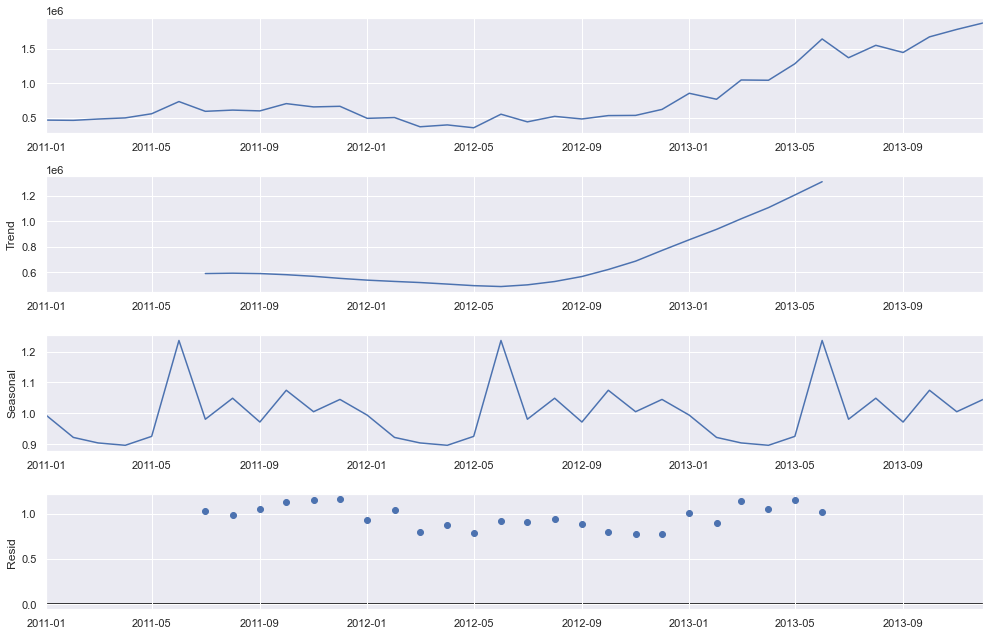

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
plt.rcParams['figure.figsize'] = (14, 9)
result = seasonal_decompose(df, model='multiplicative')
result.plot();

Nhận xét:
- Dữ liệu có tính theo mùa (seasonal) và khuynh hướng (trend) đi lên qua từng năm.

## 4. Autocorrelation plot
Dữ liệu có tính autocorrelation với lag bé hơn 6

In [18]:
from pandas.plotting import autocorrelation_plot

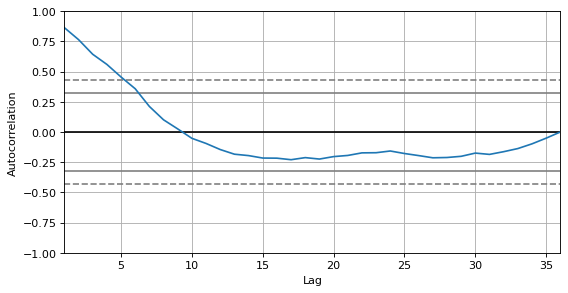

In [19]:
sns.reset_orig()
plt.figure(figsize=(8, 4), dpi= 80)
autocorrelation_plot(df)
plt.show()

## 5. Lagplot
Dữ liệu có tính autocorrelation

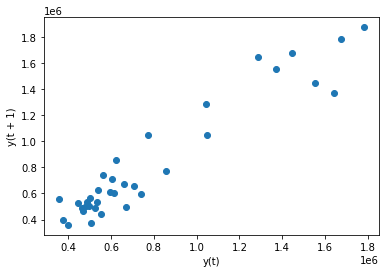

In [20]:
from pandas.plotting import lag_plot
lag_plot(df)
plt.show()

# V. SMA, EMA
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)

## 1. Simple Moving Average (SMA)
Sử dụng SMA tính trung bình của 2, 3 dữ liệu trước nó để dự đoán và quan sát

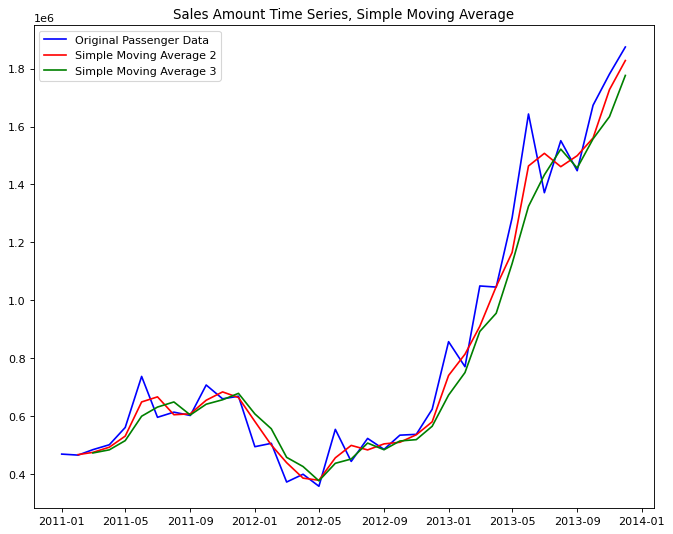

In [21]:
SMA_2 = df.rolling(2).mean()
SMA_3 = df.rolling(3).mean()

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(df, color="blue",label="Original Passenger Data")
plt.plot(SMA_2, color="red", label="Simple Moving Average 2")
plt.plot(SMA_3, color="green", label = "Simple Moving Average 3")
plt.title("Sales Amount Time Series, Simple Moving Average")
plt.legend(loc="best")

## 2. Exponential Moving Average (EMA)
Sử dụng EMA để tính trung bình của 2, 3 dữ liệu trước nó để dự đoán và quan sát

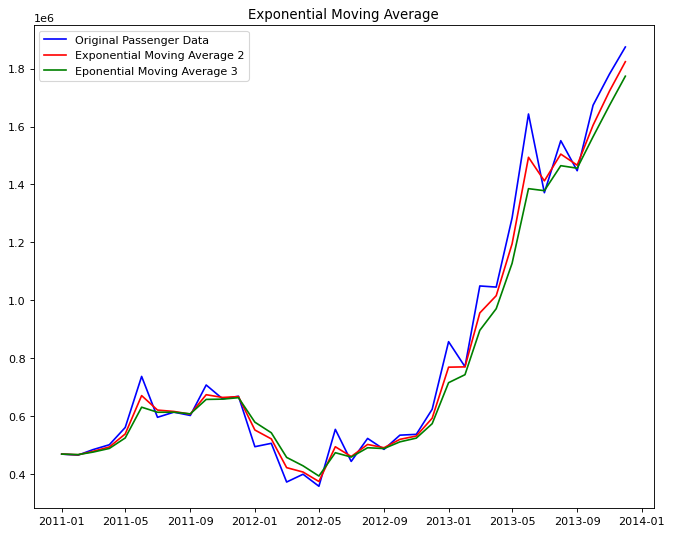

In [22]:
EMA_2 = df.ewm(span=2,adjust=False).mean()
EMA_3 = df.ewm(span=3,adjust=False).mean()

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(df,color="blue",label="Original Passenger Data")
plt.plot(EMA_2,color="red",label="Exponential Moving Average 2")
plt.plot(EMA_3,color="green",label="Eponential Moving Average 3")
plt.title("Exponential Moving Average")
plt.legend(loc="best")

# VI. Sử dụng các mô hình
1. Auto-regressive
2. AutoARIMA + ARIMA

In [23]:
X = df.values
train_size = math.floor(len(df) * 0.9)
train, test = X[1 : train_size], X[train_size-1 : ]

In [24]:
print(train.shape)

(31, 1)


In [25]:
print(test.shape)

(5, 1)


## 1. Auto-regressive
Sử dụng mô hình Auto-regressive để tìm đường hồi quy của chính nó dựa trên dữ liệu lịch sử

In [26]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

Chọn lags=2 (2 dữ liệu trước nó)

In [27]:
auto_reg = AutoReg(train, lags=2)
auto_reg_fit = auto_reg.fit()
print(f"Coefficients: {auto_reg_fit.params}")

Coefficients: [-1.56883470e+04  6.60523682e-01  4.35187420e-01]


In [28]:
predictions = auto_reg_fit.predict(start = len(train),
                                   end = len(train) + len(test) - 1,
                                   dynamic = False)
for i in range(len(predictions)):
    print('predicted = %f, expected = %f' % (predictions[i], test[i]))
mse = mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

predicted = 1605763.245630, expected = 1551065.560000
predicted = 1719960.524893, expected = 1447495.690000
predicted = 1819194.277021, expected = 1673293.410000
predicted = 1934437.739764, expected = 1780920.060000
predicted = 2053744.056745, expected = 1874360.290000
Test MSE: 30852439967.178
Test RMSE: 175648.626


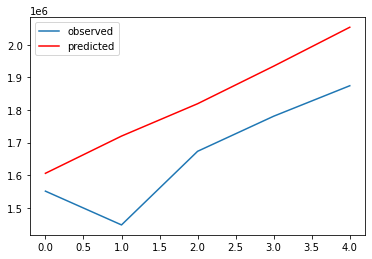

In [29]:
plt.plot(test, label='observed')
plt.plot(predictions, color="red", label='predicted')
plt.legend(loc="upper left")
plt.show()

## 2. Auto ARIMA + ARIMA
Sử dụng AutoARIMA để chọn ra bộ 3 giá trị p, d, q nhằm áp dụng vào mô hình ARIMA

In [30]:
from pmdarima.arima import auto_arima
aa_model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
aa_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=802.316, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=799.672, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=798.663, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=799.784, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=799.653, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=799.827, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=800.446, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=801.288, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=800.191, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.315 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

### Áp dụng (p, d, q) = (1, 1, 0) cho mô hình ARIMA

In [31]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(1, 1, 0))
results_ARIMA = model.fit()
forecast = results_ARIMA.predict(start = len(train),
                                end = len(train) + len(test) - 1,
                                dynamic = False)
results_ARIMA.summary()

C:\Users\quany\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\quany\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\quany\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SalesAmount   No. Observations:                   36
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -463.951
Date:                Sat, 22 Jan 2022   AIC                            931.901
Time:                        10:25:41   BIC                            935.012
Sample:                    01-01-2011   HQIC                           932.975
                         - 12-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1875      0.132     -1.415      0.157      -0.447       0.072
sigma2      1.939e+10   1.87e-12   1.04e+22      0.000    1.94e+10    1.94e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 1.36
Prob(Q):                              0.45   Prob(JB):                         0.51
Heteroskedasticity (H):               4.96   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.83e+37. Standard errors may be unstable.
"""

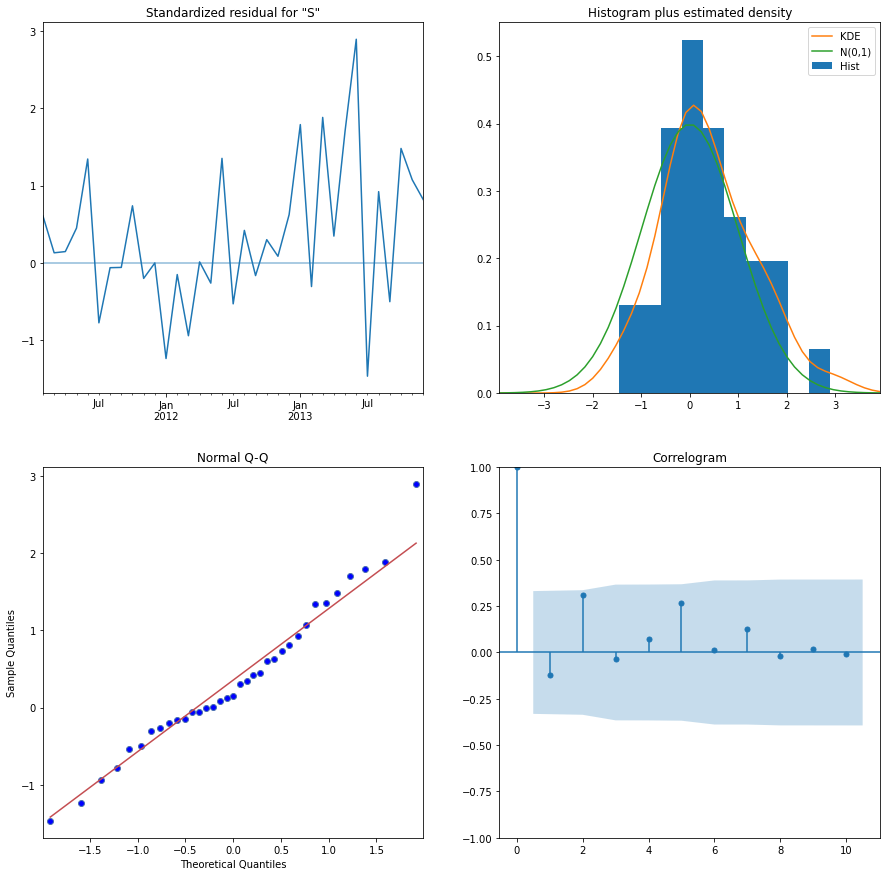

In [32]:
results_ARIMA.plot_diagnostics(figsize=(15,15))
plt.show()

### Đánh giá mô hình

In [33]:
prediction = results_ARIMA.get_prediction(start=24, dynamic=False)
prediction_ci = prediction.conf_int()

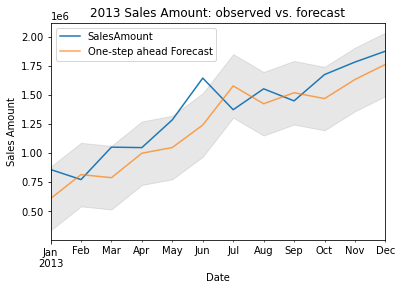

In [34]:
ax = df[df.index >= pd.to_datetime('2013-01')].plot(label='observed')

prediction.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(prediction_ci.index,
                prediction_ci.iloc[:,0],
                prediction_ci.iloc[:,1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
plt.title("2013 Sales Amount: observed vs. forecast")
plt.legend()

plt.show()

In [35]:
prediction.summary_frame()

SalesAmount,mean,mean_se,mean_ci_lower,mean_ci_upper
2013-01-01,6.082785e+05,139264.716123,3.353247e+05,8.812323e+05
2013-02-01,8.139775e+05,139264.716123,5.410237e+05,1.086931e+06
2013-03-01,7.875339e+05,139264.716123,5.145801e+05,1.060488e+06
2013-04-01,9.976900e+05,139264.716123,7.247362e+05,1.270644e+06
2013-05-01,1.046751e+06,139264.716123,7.737971e+05,1.319705e+06
2013-06-01,1.239872e+06,139264.716123,9.669178e+05,1.512825e+06
2013-07-01,1.575959e+06,139264.716123,1.303005e+06,1.848913e+06
2013-08-01,1.422570e+06,139264.716123,1.149617e+06,1.695524e+06
2013-09-01,1.517438e+06,139264.716123,1.244484e+06,1.790392e+06
2013-10-01,1.466910e+06,139264.716123,1.193957e+06,1.739864e+06


In [36]:
predicted_2013 = prediction.predicted_mean
observed_2013 = df[df.index >= pd.to_datetime('2013-01-01')]['SalesAmount']
mse = ((predicted_2013 - observed_2013)**2).mean()
rmse = math.sqrt(mse)
print('The Mean Square Error is {}'.format(round(mse, 2)))
print('The Root Mean Square Error is {}'.format(round(rmse, 2)))

The Mean Square Error is 41295576788.35
The Root Mean Square Error is 203213.13


# VII. Dự báo tổng doanh thu năm 2014

In [37]:
prediction_2014 = results_ARIMA.get_forecast(steps=12)
prediction_2014.summary_frame()

SalesAmount,mean,mean_se,mean_ci_lower,mean_ci_upper
2014-01-01,1.856844e+06,139264.716123,1.583891e+06,2.129798e+06
2014-02-01,1.860128e+06,179442.373149,1.508427e+06,2.211828e+06
2014-03-01,1.859512e+06,214792.807343,1.438526e+06,2.280499e+06
2014-04-01,1.859628e+06,244656.053888,1.380111e+06,2.339145e+06
2014-05-01,1.859606e+06,271325.514349,1.327818e+06,2.391394e+06
2014-06-01,1.859610e+06,295585.728532,1.280273e+06,2.438948e+06
2014-07-01,1.859609e+06,318002.717665,1.236336e+06,2.482883e+06
2014-08-01,1.859610e+06,338939.918386,1.195299e+06,2.523920e+06
2014-09-01,1.859610e+06,358657.019888,1.156655e+06,2.562564e+06
2014-10-01,1.859610e+06,377345.250690,1.120026e+06,2.599193e+06


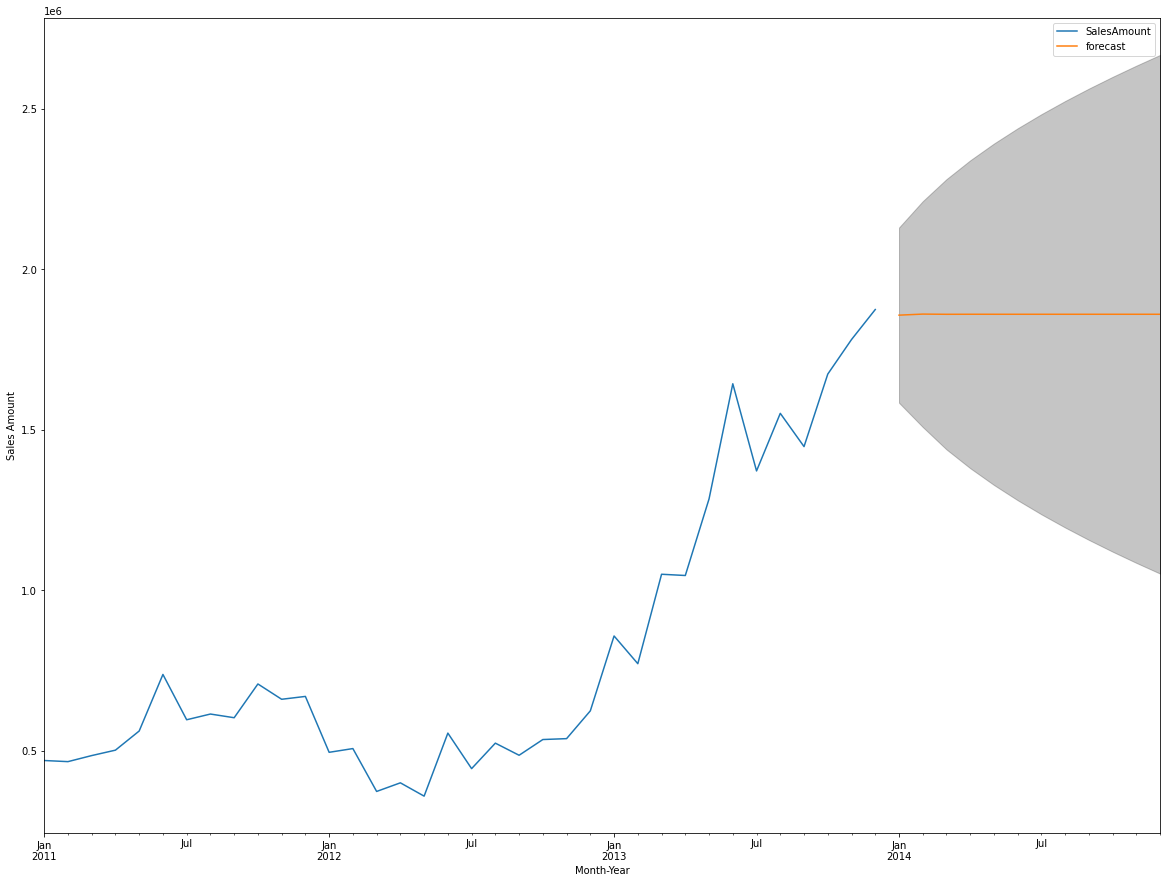

In [38]:
ax = df.plot(label='observed', figsize=(20,15))
prediction_2014.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between (prediction_2014.conf_int().index,
                 prediction_2014.conf_int().iloc[:,0],
                 prediction_2014.conf_int().iloc[:,1], color='k', alpha=0.25)

ax.set_xlabel('Month-Year')
ax.set_ylabel("Sales Amount")

plt.legend()
plt.show()

In [39]:
upper = prediction_2014.conf_int().iloc[:,1].sum()
lower = prediction_2014.conf_int().iloc[:,0].sum()
print(f"Doanh thu dự báo năm 2014 dao động từ {round(lower,2):,} đến {round(upper,2):,}")

Doanh thu dự báo năm 2014 dao động từ 15,364,226.56 đến 29,261,744.4


**Doanh thu dự báo năm 2014 dao động từ 15,364,226.56 đến 29,261,744.4**